In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('Max_column', None)

##### Import Data

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
print(f"train set shape {train.shape}\ntest set shape {test.shape}")

train set shape (2260, 11)
test set shape (1016, 10)


In [3]:
train.head(3)

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0


### Check for Missing Values

In [4]:
train.isnull().sum()

region_area_         0
ph                 336
Hardness             0
Solids               0
Chloramines          0
Sulfate            547
Conductivity         0
Organic_carbon       0
Trihalomethanes    111
Turbidity            0
Potability           0
dtype: int64

<AxesSubplot:>

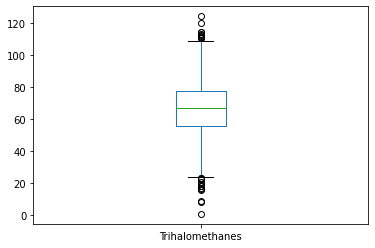

In [5]:
train['Trihalomethanes'].plot(kind = 'box')

<AxesSubplot:>

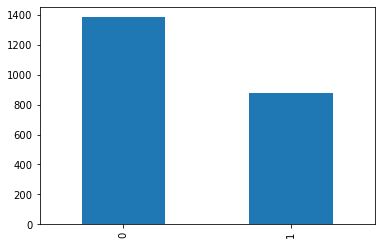

In [6]:
train['Potability'].value_counts().plot(kind = 'bar')

### Creat New Columns

In [7]:
def phStatus(row):
    if row < 6:
        value = 'Acidic'
    elif (row >= 6 or row == 7):
        value = 'Normal'
    elif row > 7:
        value = 'Alkaline'
    else:
        value = 'missing'
    return value


def hardness(row):
    if row < 120:
        value = 'Soft'
    elif (row >= 120 or row == 120):
        value = 'Moderately Hard'
    else:
        value = 'Hard'
    return value

In [8]:
col = [ 'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate','Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity',]
for x in col:
    train[x + '_' + '100']  = train[x] / 100
    test[x + '_' + '100']  = test[x] / 100

In [9]:
train['phStatus'] = train['ph'].round().apply(phStatus)
test['phStatus'] = test['ph'].round().apply(phStatus)

In [10]:
train.head(3)

,region_area_,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,ph_100,Hardness_100,Solids_100,Chloramines_100,Sulfate_100,Conductivity_100,Organic_carbon_100,Trihalomethanes_100,Turbidity_100,phStatus
0,region_area_1,3.716080,180.196811,18630.362669,6.330435,NaN,602.990359,15.285013,56.444076,4.500656,0,0.037161,1.801968,186.303627,0.063304,NaN,6.029904,0.152850,0.564441,0.045007,Acidic
1,region_area_100,4.270716,217.611599,24405.555346,7.086700,297.951852,359.623910,13.583526,54.589840,3.763906,0,0.042707,2.176116,244.055553,0.070867,2.979519,3.596239,0.135835,0.545898,0.037639,Acidic
2,region_area_1000,6.648849,232.462013,30733.808648,5.656462,344.670335,267.809179,17.863444,35.411181,4.827527,0,0.066488,2.324620,307.338086,0.056565,3.446703,2.678092,0.178634,0.354112,0.048275,Normal


### Modelling

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
X = train.drop(['region_area_', 'Potability'], axis = 1)
y = train.Potability
xtest = test.drop(['region_area_'], axis = 1)


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 2000)

In [12]:
#pip Install Feature_engine and Mlxtend
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import CountFrequencyEncoder, OneHotEncoder
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PolynomialFeatures
from feature_engine.selection import RecursiveFeatureElimination,SelectBySingleFeaturePerformance

from sklearn.metrics import roc_auc_score, f1_score
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.ensemble import  GradientBoostingClassifier,RandomForestClassifier, VotingClassifier, StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from sklearn.linear_model import Lasso, RidgeClassifier, LogisticRegression
import lightgbm as lgbm
import xgboost as xgb
from catboost import CatBoostClassifier


#Filling Missing Values
mean_imputer = MeanMedianImputer(imputation_method = 'mean')
median_imputer = MeanMedianImputer(imputation_method = 'median')
cat_imputer = CategoricalImputer(imputation_method = 'frequent')
cat_imputer_2 = CategoricalImputer(imputation_method = 'missing')

#Outliers
capper = Winsorizer(capping_method='iqr', tail='right', fold=3, variables = ['ph', 'Hardness', 'Solids', 
                      'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity',])

#Hadling categorical variables
fre_enc = CountFrequencyEncoder(encoding_method='frequency', variables =['phStatus',],
                               ignore_format = True)
one_enc = OneHotEncoder(variables =['phStatus',], drop_last = True)

#scaling
scale = QuantileTransformer()
sd = StandardScaler()
#PolynomialFeatures
poly = PolynomialFeatures(degree = 2, interaction_only=True, include_bias=False)


#Model Initialization
lgb_model = lgbm.LGBMClassifier(learning_rate = 0.09,num_leaves = 20, n_estimators = 50, class_weight = {0:0.1,1:0.9})
xgb_model = xgb.XGBClassifier(eval_metric ='logloss',objective = 'binary:logistic', learning_rate = 0.05, n_estimators = 100,
                              max_depth = 5, scale_pos_weight=4)
gbt_model = GradientBoostingClassifier(n_estimators= 50, learning_rate= 0.1,max_depth= 30, random_state=0)
cat_model = CatBoostClassifier(verbose=False,learning_rate = 0.1, iterations = 100, max_depth = 6)
lr_model = LogisticRegression(C= 100,  penalty = 'l2', class_weight = {0:0.2,1:0.8})
rf_model = RandomForestClassifier(n_estimators = 100,)
ridge_model = RidgeClassifier(alpha = 100, class_weight = {0:0.1,1:0.9})


#feature selection
tr = SelectBySingleFeaturePerformance(estimator=lr_model, scoring="f1", threshold=0.09, cv=5)

### Pipelines

In [13]:
pipe = Pipeline(
    [('mean_imputer', mean_imputer),
     ('fre_enc', fre_enc),
     ('poly', poly),
     ('model', lgb_model)
    ]
)

pipe1 = Pipeline(
    [('mean_imputer', mean_imputer),
     ('fre_enc', fre_enc),
     ('poly', poly),
     ('model', cat_model)
    ]
)

pipe2 = Pipeline(
    [('mean_imputer', mean_imputer),
     ('one_enc', one_enc),
      ('poly', poly),
     ('model', xgb_model)
    ]
)

pipe3 = Pipeline(
    [('mean_imputer', median_imputer),
     ('fre_enc', fre_enc),
     ('poly', poly),
     ('sd', sd),
     ('model', lr_model)
    ]
)

pipe4 = Pipeline(
    [('mean_imputer', median_imputer),
     ('fre_enc', fre_enc),
     ('sd', sd),
     ('poly', poly),
     ('model', ridge_model)
    ]
)

In [14]:
vote_model = VotingClassifier(estimators = [('pipe', pipe), ('pipe2', pipe2), ('pipe3', pipe3),
                                            ('pipe1', pipe1)], 
                              voting = 'soft', weights = [0.6, 0.2, 0.1, 0.1])

In [15]:
stack_model = StackingClassifier(estimators= [('pipe', pipe), ('pipe1', pipe2), ('pipe4', pipe4), ('pipe3', pipe3)],
                            final_estimator= pipe3, 
                            )

In [16]:
vote_model.fit(x_train, y_train)

VotingClassifier(estimators=[('pipe',
                              Pipeline(steps=[('mean_imputer',
                                               MeanMedianImputer(imputation_method='mean')),
                                              ('fre_enc',
                                               CountFrequencyEncoder(encoding_method='frequency',
                                                                     ignore_format=True,
                                                                     variables=['phStatus'])),
                                              ('poly',
                                               PolynomialFeatures(include_bias=False,
                                                                  interaction_only=True)),
                                              ('model',
                                               LGBMClassifier(class_weight={0: 0.1,
                                                                            1: 0.9},
         

In [17]:
train_pred = vote_model.predict(x_train) 
test_pred = vote_model.predict(x_test)
print(f"AUC score on the train set is {f1_score(y_train, train_pred)}\nAUC score on the test set is {f1_score(y_test, test_pred)} ")

AUC score on the train set is 0.690257754477938
AUC score on the test set is 0.5971223021582734 


#### Fit on Entire Data

In [18]:
vote_model.fit(X, y)

VotingClassifier(estimators=[('pipe',
                              Pipeline(steps=[('mean_imputer',
                                               MeanMedianImputer(imputation_method='mean')),
                                              ('fre_enc',
                                               CountFrequencyEncoder(encoding_method='frequency',
                                                                     ignore_format=True,
                                                                     variables=['phStatus'])),
                                              ('poly',
                                               PolynomialFeatures(include_bias=False,
                                                                  interaction_only=True)),
                                              ('model',
                                               LGBMClassifier(class_weight={0: 0.1,
                                                                            1: 0.9},
         

In [19]:
sub_test = vote_model.predict(xtest)

In [20]:
sub = pd.DataFrame({'region_area_': test['region_area_'], 'Potability': sub_test})
sub.head(3)

,region_area_,Potability
0,region_area_0,1
1,region_area_10,1
2,region_area_1006,1


In [21]:
sub.Potability.value_counts()

1    831
0    185
Name: Potability, dtype: int64

### OR

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
fold=KFold(n_splits=5)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    preds= vote_model.predict(X_test)
    print("err: ",f1_score(y_test,preds))
    errcb2.append(f1_score(y_test,preds))
    p2 = vote_model.predict(xtest)
    y_pred_totcb2.append(p2)

err:  0.6992753623188406
err:  0.595289079229122
err:  0.6374501992031872
err:  0.8273716951788491
err:  0.5581395348837209


In [24]:
from scipy.stats import mode
m = mode(y_pred_totcb2)[0]
m = pd.Series(m[0])

In [25]:
sub1 = pd.DataFrame({'region_area_': test['region_area_'], 'Potability': m})
sub1.head(3)

,region_area_,Potability
0,region_area_0,1
1,region_area_10,1
2,region_area_1006,1


In [26]:
sub1.Potability.value_counts()

1    831
0    185
Name: Potability, dtype: int64

In [ ]:
sub1.to_csv('vote1.csv', index = False)